In [1]:
import numpy as np
import pandas as pd
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.base import TransformerMixin
from sklearn.decomposition import FastICA#, TruncatedSVD, PCA, NMF
from sklearn.preprocessing import StandardScaler
import re
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from lime import submodular_pick

In [2]:
tweets = pd.read_csv('COVID19_Dataset-text_labels_only.csv')

# to convert contractions picked up by word_tokenize() into full words
contractions = {
    "n't": 'not',
    "'ve": 'have',
    "'s": 'is',  # note that this will include possessive nouns
    'gonna': 'going to',
    'gotta': 'got to',
    "'d": 'would',
    "'ll": 'will',
    "'re": 'are',
    "'m": 'am',
    'wanna': 'want to'
}


# to convert nltk_pos tags to wordnet-compatible PoS tags
def convert_pos_wordnet(tag):
    tag_abbr = tag[0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }

    if tag_abbr in tag_dict:
        return tag_dict[tag_abbr]


class Text2Embed(TransformerMixin):
    """ Description:
        Transformer that takes in a list of strings, calculates the word-context matrix
        (with any specified transformations), reduces the dimensionality of these word
        embeddings, and then provides the text embeddings of a (new) list of texts
        depending on which words in the "vocab" occur in the (new) strings.
    """

    # initialize class & private variables
    def __init__(self,
                 window_size=4,
                 remove_stopwords=True,
                 add_start_end_tokens=True,
                 lowercase=False,
                 lemmatize=False,
                 pmi=False,
                 spmi_k=1,
                 laplace_smoothing=0,
                 pmi_positive=False,
                 sppmi_k=1,
                 n_components=250,
                 random_state=4):

        """ Params:
                window_size: size of +/- context window (default = 4)
                remove_stopwords: boolean, whether or not to remove NLTK English stopwords
                add_start_end_tokens: boolean, whether or not to append <START> and <END> to the
                beginning/end of each document in the corpus (default = True)
                lowercase: boolean, whether or not to convert words to all lowercase
                lemmatize: boolean, whether or not to lemmatize input text
                pmi: boolean, whether or not to compute pointwise mutual information
                spmi_k: numeric, shifted pmi value
                pmi_positive: boolean, whether or not to compute positive PMI
                sppmi_k: numeric, shifted ppmi value
                n_components: number of components for PCA/FastICA
                random_state: set seed for FastICA
        """
        self.window_size = window_size
        self.remove_stopwords = remove_stopwords
        self.add_start_end_tokens = add_start_end_tokens
        self.lowercase = lowercase
        self.lemmatize = lemmatize
        self.pmi = pmi
        self.spmi_k = spmi_k
        self.laplace_smoothing = laplace_smoothing
        self.pmi_positive = pmi_positive
        self.sppmi_k = sppmi_k
        self.corpus = None
        self.clean_corpus = None
        self.vocabulary = None
        self.X = None
        self.doc_terms_lists = None
        self.ica = FastICA(n_components=n_components, random_state=random_state)
        self.scaler = StandardScaler()
        self.word_embeddings = None
        self.text_embeddings = None

    def fit(self, corpus, y=None):

        """ Learn the dictionary of all unique tokens for given corpus. Compute the co-occurrence matrix
            for input corpus and window_size, using term dictionary. Reduce dimensionality of embeddings.

            Params:
                corpus: list of strings

            Returns: self
        """
        self.corpus = corpus

        term_dict = dict()
        k = 0
        corpus_words = []
        clean_corpus = []
        doc_terms_lists = []
        detokenizer = TreebankWordDetokenizer()
        lemmatizer = WordNetLemmatizer()

        for text in corpus:
            text = re.sub(r'[_~`@$%^&*[\]+=\|}{\"\'<>/]+', '', text)

            words = word_tokenize(text)

            if self.remove_stopwords:
                clean_words = []
                for word in words:
                    if word.lower() not in set(stopwords.words('english')):
                        clean_words.append(word)
                words = clean_words

            if self.lowercase:
                clean_words = []
                for word in words:
                    clean_words.append(word.lower())

                words = clean_words

            if self.lemmatize:
                clean_words = []
                for word in words:
                    PoS_tag = pos_tag([word])[0][1]

                    # to change contractions to full word form
                    if word in contractions:
                        word = contractions[word]

                    if PoS_tag[0].upper() in 'JNVR':
                        word = lemmatizer.lemmatize(word, convert_pos_wordnet(PoS_tag))
                    else:
                        word = lemmatizer.lemmatize(word)

                    clean_words.append(word)

                words = clean_words

            # detokenize trick taken from this StackOverflow post:
            # https://stackoverflow.com/questions/21948019/python-untokenize-a-sentence
            # and NLTK treebank documentation:
            # https://www.nltk.org/_modules/nltk/tokenize/treebank.html
            text = detokenizer.detokenize(words)
            clean_corpus.append(text)

            [corpus_words.append(word) for word in words]

            if self.add_start_end_tokens:
                words = ['<START>'] + words + ['<END>']

            doc_terms_lists.append(words)

        self.clean_corpus = clean_corpus

        self.doc_terms_lists = doc_terms_lists

        corpus_words = list(set(corpus_words))

        if self.add_start_end_tokens:
            corpus_words = ['<START>'] + corpus_words + ['<END>']

        corpus_words = sorted(corpus_words)

        for el in corpus_words:
            term_dict[el] = k
            k += 1

        self.vocabulary = term_dict

        num_terms = len(self.vocabulary)
        window = self.window_size
        X = np.full((num_terms, num_terms), self.laplace_smoothing)

        for el in range(len(clean_corpus)):
            words = doc_terms_lists[el]

            # Construct word-context matrix
            for i in range(len(words)):
                target = words[i]

                # grab index from dictionary
                target_dict_index = self.vocabulary[target]

                # find left-most and right-most window indices for each target word
                left_end_index = max(i - window, 0)
                right_end_index = min(i + window, len(words) - 1)

                # loop over all words within window
                # NOTE: this will include the target word; make sure to skip over it
                for j in range(left_end_index, right_end_index + 1):

                    # skip "context word" where the "context word" index is equal to the
                    # target word index
                    if j != i:
                        context_word = words[j]

                        # count co-occurrence of target and context words
                        X[target_dict_index, self.vocabulary[context_word]] += 1

        # if pmi = True, compute pmi matrix from word-context raw frequencies
        # more concise code taken from this StackOverflow post:
        # https://stackoverflow.com/questions/58701337/how-to-construct-ppmi-matrix-from-a-text-corpus
        if self.pmi:
            denom = X.sum()
            col_sums = X.sum(axis=0)
            row_sums = X.sum(axis=1)

            expected = np.outer(row_sums, col_sums) / denom

            X = X / expected

            for i in range(X.shape[0]):
                for j in range(X.shape[1]):

                    if X[i, j] > 0:
                        X[i, j] = np.log(X[i, j]) - np.log(self.spmi_k)

                        if self.pmi_positive:
                            X[i, j] = max(X[i, j] - np.log(self.sppmi_k), 0)

        # note that X is a dense matrix
        self.X = X

        word_embeddings = self.scaler.fit_transform(self.X)
        word_embeddings = self.ica.fit_transform(word_embeddings)

        # transformed WordICA embeddings
        self.word_embeddings = word_embeddings

        return self

    def transform(self, new_corpus=None, y=None):

        """ Get text embeddings for given corpus, using term dictionary and word embeddings obtained
            with fit method.

            Returns: text embeddings (shape: num texts by embedding dimensions)
        """
        lemmatizer = WordNetLemmatizer()
        #if type(new_corpus) != list:
            #exit()

        for k in range(len(new_corpus)):
            text = new_corpus[k]
            text = re.sub(r'[_~`@$%^&*[\]+=\|}{\"\'<>/]+', '', text)
            text_vec = np.zeros(self.word_embeddings.shape[1])
            words = word_tokenize(text)
            tracker = 0  # to track whether we've encountered a word for which we have an embedding (in each tweet)

            if self.remove_stopwords:
                clean_words = []
                for word in words:
                    if word.lower() not in set(stopwords.words('english')):
                        clean_words.append(word)
                words = clean_words

            if self.lowercase:
                clean_words = []
                for word in words:
                    clean_words.append(word.lower())

                words = clean_words

            if self.lemmatize:
                clean_words = []
                for word in words:
                    PoS_tag = pos_tag([word])[0][1]

                    # to change contractions to full word form
                    if word in contractions:
                        word = contractions[word]

                    if PoS_tag[0].upper() in 'JNVR':
                        word = lemmatizer.lemmatize(word, convert_pos_wordnet(PoS_tag))
                    else:
                        word = lemmatizer.lemmatize(word)

                    clean_words.append(word)

                words = clean_words

            if self.add_start_end_tokens:
                words = ['<START>'] + words + ['<END>']

            for i in range(len(words)):
                word = words[i]
                if word in self.vocabulary:
                    word_embed_vec = self.word_embeddings[self.vocabulary[word], :]
                    if tracker == 0:
                        text_matrix = word_embed_vec
                    else:
                        text_matrix = np.vstack((text_matrix, word_embed_vec))

                    # only increment if we have come across a word in the embeddings dictionary
                    tracker += 1

            for j in range(len(text_vec)):
                text_vec[j] = text_matrix[:, j].mean()

            if k == 0:
                full_matrix = text_vec
            else:
                full_matrix = np.vstack((full_matrix, text_vec))

        self.text_embeddings = full_matrix

        return self.text_embeddings.copy()

In [3]:
# instantiate embedder
embedder = Text2Embed(window_size = 15, lowercase = True, lemmatize = True, pmi = True)
embedder.fit(tweets['Tweet'])

In [4]:
embedded_tweets = embedder.transform(tweets['Tweet'])

In [5]:
embedded_tweets.shape

(560, 250)

In [6]:
# instantiate classification algorithm

# round 1 winner
svc = SVC(C = 1, kernel = 'rbf', probability = True)

class1_train_indices = list(range(100))
class0_train_indices = list(range(280,380))

train_X = embedded_tweets[[class1_train_indices + class0_train_indices],:][0]

hundred_ones = [1]*100
hundred_zeros = [0]*100
train_Y = hundred_ones + hundred_zeros

# fit SVC model on training subset of tweet embeddings
svc.fit(train_X, train_Y)

SVC(C=1, probability=True)

In [7]:
class1_test_indices = list(range(100,280))
class0_test_indices = list(range(380,560))
test_X = tweets['Tweet'][class1_test_indices + class0_test_indices]
test_X = test_X.reset_index(drop = True)

In [8]:
c = make_pipeline(embedder, svc)

explainer = LimeTextExplainer(class_names = ['Reliable', 'Unreliable'])

In [9]:
# find unreliable tweets predicted as reliable
for i in range(100,280):
    if svc.predict(embedded_tweets[i].reshape(1,-1)) != tweets['Is_Unreliable'][i]:
        print(i)


100
113
136
146
193
213
219
222
238


In [10]:
svc.predict(embedded_tweets[100].reshape(1,-1))

array([0])

In [11]:
tweets['Tweet'][100]

'#coronavirus #virus Reasons to buy back stocks today 1500 new cases 60 deaths 2700 recovered #markets #portfolio'

In [12]:
wrongPredict_exp = explainer.explain_instance(tweets['Tweet'][100], c.predict_proba, num_features = 6)
wrongPredict_exp.as_list()

[('cases', -0.19393095841158178),
 ('new', -0.14484235628810083),
 ('deaths', -0.09198812664803652),
 ('60', 0.06941335119222543),
 ('coronavirus', -0.057026746565421935),
 ('buy', 0.04756727124584794)]

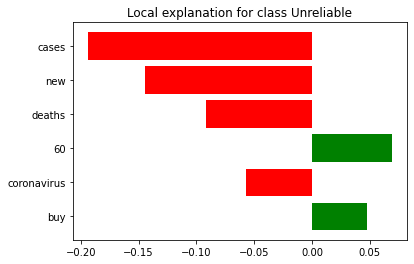

In [13]:
%matplotlib inline
fig = wrongPredict_exp.as_pyplot_figure()

In [14]:
# Establish list
explanations = []

# Loop through test set of unreliable tweets:
for idx in range(100,280):
    tweet = tweets['Tweet'][idx]
    num_words = len(re.split("\W+", tweet))
    exp = explainer.explain_instance(tweets['Tweet'][idx], c.predict_proba, num_features = num_words)
    explanations.append(exp.as_list())
    if idx in [125, 150, 175, 200, 225, 250]:
        print(idx)

125
150
175
200
225
250


In [15]:
len(explanations)

180

In [16]:
explanations[0]

[('cases', -0.20405363785689484),
 ('new', -0.155064717978664),
 ('deaths', -0.10207417820647408),
 ('coronavirus', -0.06698967143404387),
 ('60', 0.05479825610293619),
 ('buy', 0.037730810152627504),
 ('stocks', 0.030866492206280807),
 ('back', 0.02862044153289094),
 ('portfolio', 0.019228230730050148),
 ('virus', -0.01764508279082087),
 ('Reasons', 0.01762324495375404),
 ('markets', 0.017075460328202865),
 ('1500', 0.015832371859270025),
 ('recovered', 0.015536797813199194),
 ('2700', 0.015119529843808394),
 ('to', -0.002003116629506429),
 ('today', 0.0003091368069083442)]

In [17]:
vocab_list = []
for subList in explanations:
    for el in subList:
        if el[0] not in vocab_list:
            vocab_list.append(el[0])
len(vocab_list)

1659

In [18]:
[el for el in vocab_list]

['cases',
 'new',
 'deaths',
 'coronavirus',
 '60',
 'buy',
 'stocks',
 'back',
 'portfolio',
 'virus',
 'Reasons',
 'markets',
 '1500',
 'recovered',
 '2700',
 'to',
 'today',
 'Coronavirus',
 'inside',
 '1',
 '2',
 'cotton',
 'anus',
 'solutions',
 'water',
 'joke',
 'Dip',
 'viruses',
 'bottle',
 'place',
 'spit',
 'cleric',
 'Ayatollahs',
 'sleep',
 'blessings',
 'drinking',
 'have',
 'a',
 'him',
 'all',
 'and',
 'other',
 'of',
 'in',
 'before',
 'it',
 'for',
 'Not',
 'Take',
 'the',
 'oil',
 'you',
 'good',
 'kitchen',
 'cookies',
 'longer',
 'meeting',
 'leftovers',
 'Except',
 'staff',
 'set',
 'we',
 'out',
 'Because',
 'from',
 'will',
 'no',
 'Trump',
 'US',
 'people',
 'President',
 'visit',
 'amp',
 'embrace',
 'personal',
 'responsibility',
 'contract',
 'has',
 'who',
 'vaccine',
 'finding',
 'Israelis',
 'end',
 '100',
 'unironic',
 'roughly',
 'NYT',
 'write',
 'likely',
 'do',
 'is',
 'If',
 'up',
 'an',
 'reason',
 'reached',
 'fallen',
 'Sflecce',
 'D19VP',
 'behi

In [19]:
table1Words = [
    'blame',
    'accuse',
    'refuse',
    'catastrophe',
    'emergency',
    'chaos',
    'crisis',
    'evil',
    'fight',
    'danger',
    'hysteria',
    'panic',
    'paranoia',
    'fear',
    'fears',
    'laugh',
    'stupidity',
    'hear',
    'see',
    'fee',
    'perceive',
    'look',
    'appear',
    'suggest'
    'believe',
    'believed',
    'pretend',
    'martial',
    'kill',
    'killing',
    'kills',
    'killed',
    'die',
    'threat',
    'weapon',
    'weaponize',
    'weaponizing',
    'knife',
    'ussr',
    'japan',
    'chernobyl',
    'wuhan',
    'china',
    'foreigners',
    'cat',
    'cats',
    'dog',
    'dogs',
    'i',
    'me',
    'mine',
    'my',
    'you',
    'yours',
    'your',
    'we',
    'our',
    'propaganda',
    'fake',
    'conspiracy',
    'claim',
    'claims',
    'claiming',
    'misleading',
    'hoax',
    'cure',
    'breakthrough',
    'bitch',
    'wtf',
    'dogbreath',
    'zombie',
    'junkies',
    'hell',
    'screwed',
    'fuck',
    'fucking',
    'fucked',
    'fuckin',
    'wth',
    'secular',
    'bible',
    'maga',
    'magat',
    'genetic',
    'hillary',
    'clinton',
    'fundamentalist',
    'market',
    'communist',
    'nazi',
    'stock',
    'bank',
    'economy',
    'economic',
    'money',
    'cost',
    'costs',
    'election',
    'campaign',
    'presidential',
    'impeachment',
    'rally',
    'rallies',
    'base',
    'president',
    'trump',
    'war',
    'wwiii',
    'asteroid',
    'banknotes',
    'dangerous',
    'invent',
    'invented',
    'iran',
    'lie',
    'lies',
    'lying',
    'lied',
    'liar',
    'liars',
    'lmfao',
    'lmfaoooooo',
    'misinformation',
    'news',
    'media',
    'financial',
    'propagandawars',
    'antidote'
]

In [20]:
filtered_vocab = [el for el in vocab_list if el.lower() in table1Words]

In [21]:
filtered_vocab

['you',
 'we',
 'Trump',
 'President',
 'You',
 'your',
 'TRUMP',
 'media',
 'look',
 'asteroid',
 'WWIII',
 'We',
 'BANKNOTES',
 'dangerous',
 'economic',
 'My',
 'believed',
 'knife',
 'fight',
 'EMERGENCY',
 'NEWS',
 'evil',
 'invented',
 'Iran',
 'chaos',
 'refuse',
 'lying',
 'me',
 'Misleading',
 'junkies',
 'Zombie',
 'market',
 'Market',
 'stock',
 'claims',
 'Wuhan',
 'China',
 'conspiracy',
 'killing',
 'lied',
 'LMFAOOOOOO',
 'threat',
 'crisis',
 'Bank',
 'panic',
 'Hell',
 'Stupidity',
 'Claims',
 'Fears',
 'Paranoia',
 'hoax',
 'claiming',
 'weaponizing',
 'Fear',
 'campaign',
 'Kills',
 'my',
 'fucked',
 'I',
 'our',
 'base',
 'rallies',
 'emergency',
 'screwed',
 'weapon',
 'Rallies',
 'Clinton',
 'laugh',
 'cure',
 'DIE',
 'lie',
 'Hoax',
 'lies',
 'economy',
 'dog',
 'see',
 'news',
 'pretend',
 'misinformation',
 'cost',
 'Communist',
 'fuckin',
 'kill',
 'fear',
 'financial',
 'hysteria',
 'fucking',
 'kills',
 'killed',
 'Fake',
 'war',
 'Killed',
 'fears',
 'impea

In [22]:
myDict = dict()

for i in range(len(vocab_list)):
    myDict[vocab_list[i]] = i
    
myDict

{'cases': 0,
 'new': 1,
 'deaths': 2,
 'coronavirus': 3,
 '60': 4,
 'buy': 5,
 'stocks': 6,
 'back': 7,
 'portfolio': 8,
 'virus': 9,
 'Reasons': 10,
 'markets': 11,
 '1500': 12,
 'recovered': 13,
 '2700': 14,
 'to': 15,
 'today': 16,
 'Coronavirus': 17,
 'inside': 18,
 '1': 19,
 '2': 20,
 'cotton': 21,
 'anus': 22,
 'solutions': 23,
 'water': 24,
 'joke': 25,
 'Dip': 26,
 'viruses': 27,
 'bottle': 28,
 'place': 29,
 'spit': 30,
 'cleric': 31,
 'Ayatollahs': 32,
 'sleep': 33,
 'blessings': 34,
 'drinking': 35,
 'have': 36,
 'a': 37,
 'him': 38,
 'all': 39,
 'and': 40,
 'other': 41,
 'of': 42,
 'in': 43,
 'before': 44,
 'it': 45,
 'for': 46,
 'Not': 47,
 'Take': 48,
 'the': 49,
 'oil': 50,
 'you': 51,
 'good': 52,
 'kitchen': 53,
 'cookies': 54,
 'longer': 55,
 'meeting': 56,
 'leftovers': 57,
 'Except': 58,
 'staff': 59,
 'set': 60,
 'we': 61,
 'out': 62,
 'Because': 63,
 'from': 64,
 'will': 65,
 'no': 66,
 'Trump': 67,
 'US': 68,
 'people': 69,
 'President': 70,
 'visit': 71,
 'amp':

In [23]:
myDictFiltered = dict()

for i in range(len(filtered_vocab)):
    myDictFiltered[filtered_vocab[i]] = i
    
myDictFiltered

{'you': 0,
 'we': 1,
 'Trump': 2,
 'President': 3,
 'You': 4,
 'your': 5,
 'TRUMP': 6,
 'media': 7,
 'look': 8,
 'asteroid': 9,
 'WWIII': 10,
 'We': 11,
 'BANKNOTES': 12,
 'dangerous': 13,
 'economic': 14,
 'My': 15,
 'believed': 16,
 'knife': 17,
 'fight': 18,
 'EMERGENCY': 19,
 'NEWS': 20,
 'evil': 21,
 'invented': 22,
 'Iran': 23,
 'chaos': 24,
 'refuse': 25,
 'lying': 26,
 'me': 27,
 'Misleading': 28,
 'junkies': 29,
 'Zombie': 30,
 'market': 31,
 'Market': 32,
 'stock': 33,
 'claims': 34,
 'Wuhan': 35,
 'China': 36,
 'conspiracy': 37,
 'killing': 38,
 'lied': 39,
 'LMFAOOOOOO': 40,
 'threat': 41,
 'crisis': 42,
 'Bank': 43,
 'panic': 44,
 'Hell': 45,
 'Stupidity': 46,
 'Claims': 47,
 'Fears': 48,
 'Paranoia': 49,
 'hoax': 50,
 'claiming': 51,
 'weaponizing': 52,
 'Fear': 53,
 'campaign': 54,
 'Kills': 55,
 'my': 56,
 'fucked': 57,
 'I': 58,
 'our': 59,
 'base': 60,
 'rallies': 61,
 'emergency': 62,
 'screwed': 63,
 'weapon': 64,
 'Rallies': 65,
 'Clinton': 66,
 'laugh': 67,
 'cure

In [24]:
my_matrix = np.zeros((len(explanations), len(vocab_list)))

for i in range(len(explanations)):
    expl = explanations[i]
    for j in range(len(expl)):
        word = expl[j][0]
        val = expl[j][1]
        
        if val > 0:
            my_matrix[i, myDict[word]] = 1
        
        if val < 0:
            my_matrix[i, myDict[word]] = -1

In [25]:
my_matrix

array([[-1., -1., -1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  1.]])

In [26]:
myMatFilt = np.zeros((len(explanations), len(vocab_list)))

for i in range(len(explanations)):
    expl = explanations[i]
    for j in range(len(expl)):
        word = expl[j][0]
        val = expl[j][1]
        
        if word in filtered_vocab:
        
            if val > 0:
                myMatFilt[i, myDictFiltered[word]] = 1

            if val < 0:
                myMatFilt[i, myDictFiltered[word]] = -1

In [27]:
myMatFilt

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Normalized by number of nonzero elements (per tweet)

### Penalize for associating Table 1 word with wrong class

In [28]:
tweet_scores = []
totalNonZero = 0
for row in myMatFilt:
    rowSum = 0
    nonZero = 0
    for el in row:
        rowSum += el
        if el != 0:
            nonZero += 1
            totalNonZero += 1
    
    if nonZero > 0:
        score = rowSum/nonZero
    else:
        score = 0
    
    tweet_scores.append(score)

In [29]:
np.array(tweet_scores).mean()

0.3531481481481481

In [30]:
totalNonZero

330

### Only count if Table 1 word associated with correct class

In [31]:
tweet_scores = []
totalNonZero = 0
for row in myMatFilt:
    rowSum = 0
    nonZero = 0
    for el in row:
        if el > 0:
            rowSum += el
        if el != 0:
            nonZero += 1
            totalNonZero += 1
    
    if nonZero > 0:
        score = rowSum/nonZero
    else:
        score = 0
    
    tweet_scores.append(score)

In [32]:
np.array(tweet_scores).mean()

0.5821296296296297

According to LIME, the algorithm associated 58.2% of Table 1 words with the unreliable class.

## Normalized by total number of Table 1 vocab words

In [33]:
tweet_scores = np.sum(myMatFilt, axis = 1)
tweet_scores = tweet_scores/myMatFilt.shape[1]

In [34]:
# overall score
tweet_scores.mean()

0.000482218203737191

I think this is the wrong way to do things because it "penalizes" (drags down the tweet score by increasing the denominator) for words that didn't occur in each tweet.

## Save list of explanations

In [35]:
import pickle

In [36]:
with open('explanation_list', 'wb') as f:
    pickle.dump(explanations, f)